# MT Quality Score Calculator for Embedding-based Metrics
This is a Jupyter Notebook for calculating modern embedding-based metrics for MT quality evaluation, here *BERTScore* and *COMET*. Traditional MT quality scores such as F-Measure, BLEU or TER rely on exact string matching to calculate the similarity or dissimilarity between a machine-translated hypothesis and a human-translated (or post-edited) reference (see the notebook on traditional MT quality scores). Embedding-based metrics, on the other hand, use the concept of *word embeddings* to calculate the (dis)similarity between hypothesis and reference based on the relative proximity of their embeddings in high-dimensional vector space (see the notebooks on word embeddings for NMT).  

Within these modern embedding-based metrics, a distinction can be made between metrics which rely solely on semantic similarity between hypothesis and reference based on proximity in vector space, and metrics which rely both on this semantic similarity in vector space and on previous human quality judgements on similar hypothesis-reference pairs. BERTScore is an example of a 'semantics-only score', and COMET is an example of a 'semantics plus human judgement score'. The two scores will be covered in this notebook.  


## 0 Housekeeping
First, we need to install the packages required to compute BERTScore and COMET. BERTScore is implemented as part of the bert-score package available in the [official BERTScore GitHub repository](https://github.com/Tiiiger/bert_score). COMET is implemented as part of the unbabel-comet package available in the [official COMET GitHub repository](https://github.com/Unbabel/COMET). Since embedding-based metrics rely on large embedding models, installing these metrics and loading their will take considerably longer than installing and importing traditional MT quality scores.

## 0.1 Installing BERTScore

In [ ]:
# Get the most current version of pip 
!pip install --upgrade pip

# Install the transformers library
!pip install transformers

# Intstall BERTScore
!pip install bert-score

## 0.2 Installing COMET

In [ ]:
# Get the most current version of pip 
!pip install --upgrade pip

# Install the unbabel-comet package
!pip install unbabel-comet

# 1 Embedding-based metrics relying on semantic similarity in vector space

## 1.1 BERTScore
BERTScore was originally proposed in [Zhang et al. (2019): BERTScore: Evaluating Text Generation with BERT](https://arxiv.org/abs/1904.09675). It uses the pretrained contextual word embeddings from Google's neural language model BERT (see [Devlin et al. (2019): BERT: Pre-Training of Deep Bidirectional Transformers for Language Understanding](https://www.aclweb.org/anthology/N19-1423/)) in order to match words in hypothesis and reference sentences based on the cosine similarity of their corresponding word vectors. Based on these matched contextual word embeddings, BERTScore calculates Precision, Recall and F-Measure, which you should already be familiar with from the notebook on traditional MT quality scores.  

You may wonder why BERTScore (and COMET too, actually) uses word embeddings to compute semantic similarity between sentences when approaches like *doc2vec* (see [Le/Mikolov (2014): Distributed Representations of Sentences and Documents](https://arxiv.org/pdf/1405.4053.pdf)) allow us to compute embeddings for complete sentences and calculate similarity between these sentence vectors. The main reason is that using word embeddings allows weighting different tokens in the sentences differently according to their importance (e.g., weighting content words higher than function words or weighting rare words higher than common words, see Zhang et al. 2020:3).  

Also, BERTScore uses *contextual word embeddings* taken from Google's BERT model. You can think of these contextual word embeddings as an upgraded version of *normal* or *standard* word embeddings calculated, for example, by word2vec. These standard word embeddings are context-independent, meaning that each word is represented by just one vector, regardless of how many senses this word actually has and at which sentence positions it actually occurs. BERT, on the other hand, generates different embeddings for a word depending on its context, i.e., depending on the sense in which it is used and where in the sentence it occurs. Therefore, contextual word embeddings are more powerful representations than standard word embeddings. More information on the difference between standard and contextual word embeddings can be found [here](https://www.quora.com/What-are-the-main-differences-between-the-word-embeddings-of-ELMo-BERT-Word2vec-and-GloVe).  

The actual BERTScore computation is visualized in the figure below (taken from Zhang et al. 2020:4):

<img src="https://raw.githubusercontent.com/Tiiiger/bert_score/master/bert_score.png">

In a first step, BERT tokenizes the hypothesis (here called *candidate*) and reference sentences and converts the individual tokens into contextual word embeddings. Then, the cosine similarity between each word embedding in the hypothesis and each word embedding in the reference is calculated (see notebook on the fundamentals of word embeddings). In the figure above, this process is called *Pairwise Cosine Similarity*. In the resulting similarity matrix, we match each hypothesis token to the most similar reference token simply by identifying which pairings have the highest similarity score (so-called *greedy matching*). In the figure above, this process is called *Maximum Similarity*. Optionally, BERTScore can also give a higher weighting to rare words. To establish such rare words, BERTScore uses a measure called *inverse document frequency (idf)*, which we'll not cover here in any more detail. In the figure above, this process is called *Importance Weighting*.  
Based on the matching of the contextual embeddings according to their cosine similarity, BERTScore then calculates *Recall* ($R_{BERT}$) and *Precision* ($P_{BERT}$) and combines these two scores into an *F-Measure* score ($F_{BERT}$). So, to put it very simply, BERTScore is quite similar to the traditional F-Measure score introduced in the context of traditional MT quality metrics. The difference is that the traditional F-Measure relies on precision and recall values established by exact string matching, whereas $F_{BERT}$ uses precision and recall values that were established by computing vector similarities between contextual word embeddings in high-dimensional vector space.  
Run the following code to calculate BERTScore for a predefined hypothesis-reference pair (the sentences were taken from the original BERTScore paper). Feel free to change hypothesis and reference according to your requirements.

In [ ]:
# Import BERTScore
from bert_score import score

# Define hypothesis and reference
hypothesis = ['Experts believe November’s Black Friday could be holding back spending.']
reference = ['Experts believe that the Black Friday in November has put the brakes on spending']

# Calculate BERTScore
P, R, F1 = score(hypothesis, reference, lang="en", verbose=True)

# Print Rbert, Pbert and Fbert
print(f"\nBERTScore-Recall: {R}\n")
print(f"BERTScore-Precision: {P}\n")
print(f"BERTScore-F-Measure: {F1}")

calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.53 seconds, 1.90 sentences/sec

BERTScore-Recall: tensor([0.9512])

BERTScore-Precision: tensor([0.9491])

BERTScore-F-Measure: tensor([0.9501])


$R_{BERT}$, $P_{BERT}$ and $F_{BERT}$ are given as tensors, each containing a scalar value. The tensor for $F_{BERT}$ (*BERTScore-F-Measure* in the output above) is the final BERTscore for this hypothesis-reference pair. BERTScore rescales this output so that it lies in a range between 0 and 1, with 0 being a very poor and 1 being a very good score (so, BERTScore is a similarity measure, just as the traditional F-Measure). The hypothesis-reference pair defined above is scored very highly because the two sentences express almost the same meaning, although they differ in their respective surface forms. Due to these formal differences between hypothesis and reference, traditional MT quality scores such as F-Measure and BLEU would score them much lower than BERTScore does. 

A very conventient feature of BERTScore is its integrated plot function. Using this function, we can plot a similarity matrix four our hypothesis-reference pairs, which looks just like the matrix called *Maximum Similarity* in the figure above. Run the code below to plot your own similarity matrix:

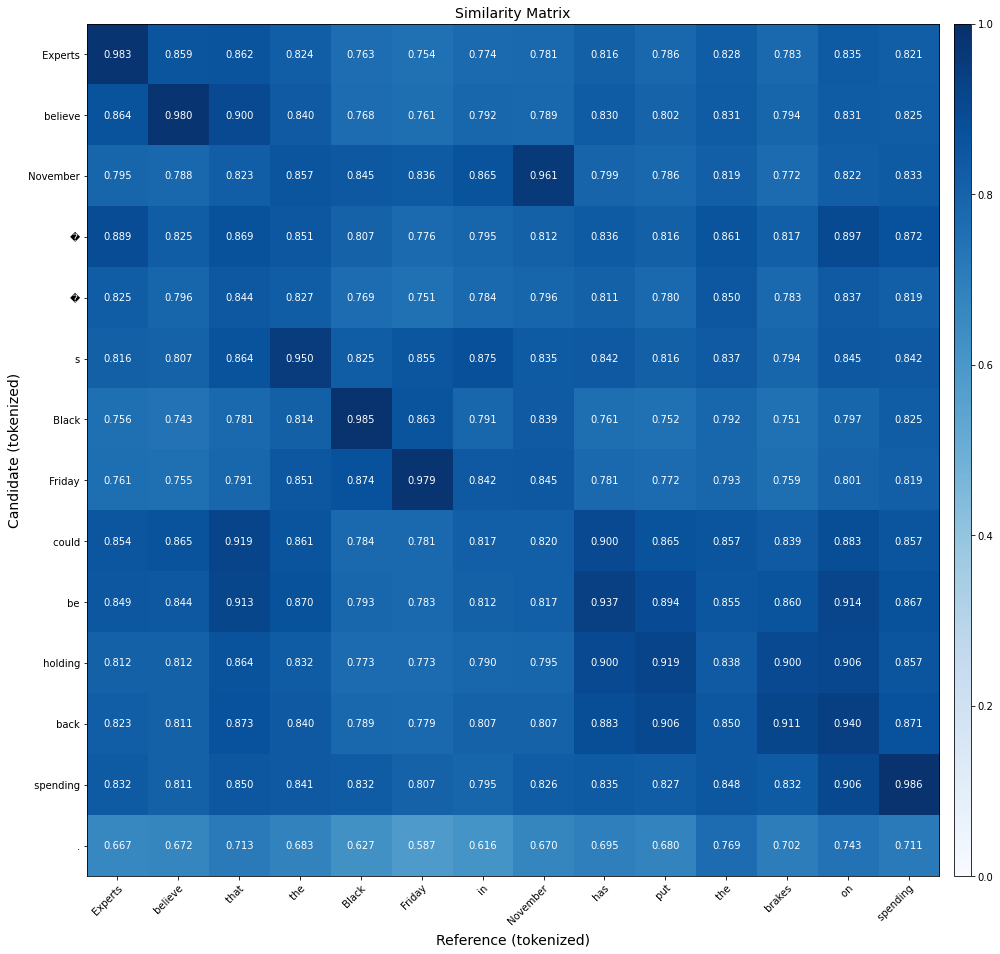

In [ ]:
# Import BERTScore's plot function
from bert_score import plot_example

# Plot the similarity matrix
hyp = hypothesis[0]
ref = reference[0]
plot_example(hyp, ref, lang="en")

The BERTScore code used in this notebook was adapted from the official [BERTScore Tutorial](https://colab.research.google.com/drive/1kpL8Y_AnUUiCxFjhxSrxCsc6-sDMNb_Q) in Google Colab.

# 2 Embedding-based metrics relying on semantic similarity in vector space and trained additionally on human quality judgements

## 2.1 COMET
**COMET** is an acronym for **C**rosslingual **O**ptimized **M**etric for **E**valuation of **T**ranslation. It was originally proposed in [Rei et al. (2020): COMET: A Neural Framework for MT Evaluation](https://www.aclweb.org/anthology/2020.emnlp-main.213/) and stands in the tradition of the METEOR metric covered in the notebook on traditional MT quality scores. Comparing METEOR and COMET serves to illustrate the contrast between previous knowledge-based approaches to artificial intelligence (AI) in natural language processing (NLP) and modern neural approaches to AI and NLP. In the knowledge-based paradigm, NLP applications had to be provided with explicit linguistic knowledge in order to be able to perform their duties. In the case of METEOR, this linguistic knowledge came in the form of a stemmer, a synonym database and (in later versions) paraphrase tables. In the neural paradigm, on the other hand, AI-based NLP applications are simply trained with large volumes of language data from which they extract and learn their own rules and patterns. The systems can then apply these learned rules and patterns when processing new data. As a result, neural MT quality metrics such as COMET (BERTScore as well) can establish semantic similarities between sentences without having to draw on explicit linguistic knowledge sources as employed by METEOR.  

In contrast to traditional MT quality metrics based on string matching, COMET uses not only the machine-translated hypothesis and the human-translated or post-edited reference sentence but also the original soure sentence. These three sentences are fed into a pretrained cross-lingual encoder which embedds them in a multilingual vector space. The cross-lingual ecoder is based on the multilingual language model *XLM-RoBERTa (XLM-R)*, which was first proposed in [Conneau et al. 2020: Unsupervised Cross-Lingual Representation Learning at Scale](https://arxiv.org/abs/1911.02116). In this multilingual vector space, not only embeddings of words from the same language but also embeddings of words from different languages cluster together based on their shared semantic meaning. Drawing on this multilingual vector space, COMET can establish both the semantic similarity between hypothesis and reference as well as the semantic similarity between source and hypothesis/reference. BERTScore, in contrast, works with embeddings from a monolingual vector space. 

In the original paper, the authors train three COMET models with three corpora incorporating human quality judgements:  

**1)** The *WMT DA-RR Corpus* is a collection of datasets each containing the following elements: a source sentence, a reference sentence and two MT hypotheses, where human evaluators had to rank one hypothesis as better and the other as worse (the guiding quality criterium was *adequacy*, and the setting was a direct assessment (DA) setting).  
**2)** The *QT21 Corpus* is a collection of datasets each containing the following elements: a source sentence, a human-translated reference sentence, an MT hypothesis and a post-edited MT hypothesis, together with a human-targeted translation edit rate (hTER) score for MT hypothesis and post-edited MT hypothesis.  
**3)** The *MQM Corpus* is a collection of datasets each containing the following elements: a source sentence, a human-translated reference sentence, an MT hypothesis and an [MQM](http://www.qt21.eu/mqm-definition/definition-2015-12-30.html) score for this hypothesis, which is derived from MQM error annotations from one or more trained annotators.  

In summary, the tree COMET models employ three different kinds of human quality judgements, 1) ranking two hypotheses based on their relative adequacy in a direct assessment (DA) setting, 2) an hTER score calculated for a raw MT hypothesis and its post-edited version, and 3) an MQM score for an MT hypothesis. According to the authors, incorporating such human quality judgements in calculating embedding-based MT quality scores makes these scores more powerful than embedding-based scores relying solely on semantic similarity in vector space (such as BERTScore). In the authors' own words: "[H]uman judgements [...] capture much more than just semantic similarity, resulting in a correlation upper-bound between human judgements and the scores produced by such judgements" (Rei et al. 2020:2692).

All three COMET models can be used to calculate COMET scores, but the authors recommed using the *wmt-large-da-estimator-1719* model, which is based on approach 1 above and which achieved the best results in terms of correlation with human quality judgements (see Rei et al. 2020:2690-2691). An overview of the available COMET models and how to load them can be found in the official [COMET GitHub repository](https://github.com/Unbabel/COMET).  

Running the code below will load the DA Estimator model: 

In [ ]:
# Loading the 'wmt-large-da-estimator-1719' model
from comet.models import download_model
model = download_model("wmt-large-da-estimator-1719")

In the DA Estimator model, the multilingual embedding space is tweaked in such a way that the distance between source/reference and the worse of the two human-ranked MT hypotheses is increased whereas the distance between source/reference and the better of the two MT hypotheses is decreased. In other words, the human quality judgements influence the configuration of this vector space. Therefore, computing similarities based on distances in this vector space will reflect both the overall semantic similarity between source, reference and the two hypotheses as well as the human quality judgement on which of the two hypotheses is better in terms of adequacy when compared to its source sentence and the corresponding human reference sentence.  

Run the code below to calcuate COMET scores based on the DA Estimator model:

In [ ]:
# Defining source, hypothesis and reference sentences
source = ["Dem Feuer konnte Einhalt geboten werden", "Schulen und Kindergärten wurden eröffnet"]
hypothesis = ["The fire could be stopped", "Schools and kindergartens were open"]
reference = ["They were able to control the fire", "Schools and kindergartens opened"]

# Converting sentences into model inputs
data = {"src": source, "mt": hypothesis, "ref": reference}
data = [dict(zip(data, t)) for t in zip(*data.values())]

# Calculate COMET scores
model.predict(data, cuda=True, show_progress=True)

Scoring hypothesis...: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


([{'mt': 'The fire could be stopped',
   'predicted_score': 0.1500970423221588,
   'ref': 'They were able to control the fire',
   'src': 'Dem Feuer konnte Einhalt geboten werden'},
  {'mt': 'Schools and kindergartens were open',
   'predicted_score': 0.8994001150131226,
   'ref': 'Schools and kindergartens opened',
   'src': 'Schulen und Kindergärten wurden eröffnet'}],
 [0.1500970423221588, 0.8994001150131226])

As you can see, you can compute COMET scores for more than one sentence simultaneously by simply adding additional strings separated by a comma. COMET will then calculate an individual score for each source-hypothesis-reference set. If you want a single corpus-level score for your MT output, just calculate the average of the individual sentence-level scores.  

The scores calculated using the DA Estimator model can be interpreted as follows:  
- The median score is 0.415992.
- Hyptheses with a score < 0.313875 are in the bottom 25%.
- Hypotheses with a score > 0.582837 are in the top 25%.

With regard to our example above, this means that the first hypothesis is a very good translation (in terms of adequacy
), whereas the second hypothesis is a rather bad translation (probably because it got the past tense wrong and therefore does not reflect the meaning of the source sentence correctly). More information on how to interpret COMET scores calculated using the different models can be found in the [official COMET documentation](https://unbabel.github.io/COMET/html/models.html). 